# 6. How to Solve ODEs with Rate Law Functions

In general, `ReactionRule` describes a mass action kinetics with no more than two reactants. In case of a reaction with a complecated rate law, `ReactionRule` could be extensible with `ReactionRuleDescriptor`. Here, we explan the use of `ReactionRuleDescriptor` especially for `ode`.

In [1]:
%matplotlib inline
from ecell4 import *
from ecell4_base import *
from ecell4_base.core import *

## 6.1. ReactionRuleDescriptor

`ReactionRule` defines reactants, products, and a kinetic rate.

In [2]:
rr1 = ReactionRule()
rr1.add_reactant(Species("A"))
rr1.add_reactant(Species("B"))
rr1.add_product(Species("C"))
rr1.set_k(1.0)
print(len(rr1.reactants()))  # => 2
print(len(rr1.products()))  # => 1
print(rr1.k())  # => 1.0
print(rr1.as_string())  # => A+B>C|1
print(rr1.has_descriptor())  # => False

2
1
1.0
A+B>C|1
False


In addition to that, `ReactionRule` could be extensible with `ReactionRuleDescriptor`.

In [3]:
desc1 = ReactionRuleDescriptorMassAction(1.0)
print(desc1.k())
rr1.set_descriptor(desc1)

1.0


`ReactionRuleDescriptor` is accessible from `ReactionRule`.

In [4]:
print(rr1.has_descriptor())
print(rr1.get_descriptor())
print(rr1.get_descriptor().k())

True
1.0


`ReactionRuleDescriptor` can store stoichiometric coefficients for each reactants:

In [5]:
desc1.set_reactant_coefficient(0, 2)  # Set a coefficient of the first reactant
desc1.set_reactant_coefficient(1, 3)  # Set a coefficient of the second reactant
desc1.set_product_coefficient(0, 4)  # Set a coefficient of the first product
print(rr1.as_string())

2*A+3*B>4*C|1


You can get the list of coefficients in the following way:

In [6]:
print(desc1.reactant_coefficients())  # => [2.0, 3.0]
print(desc1.product_coefficients())  # => [4.0]

[2.0, 3.0]
[4.0]


Please be careful that `ReactionRuleDescriptor` works properly only with `ode`.

## 6.2. ReactionRuleDescriptorPyFunc

`ReactionRuleDescriptor` provides a function to calculate a derivative (flux or velocity) based on the given values of `Species`. In this section, we will explain the way to define your own kinetic law.

In [7]:
rr1 = ReactionRule()
rr1.add_reactant(Species("A"))
rr1.add_reactant(Species("B"))
rr1.add_product(Species("C"))
print(rr1.as_string())

A+B>C|0


First, define a rate law function as a Python function. The function must accept six arguments and return a floating number. The first and second lists contain a value for each reactants and products respectively. The third and fourth represent volume and time. The coefficients of reactants and products are given in the last two arguments.

In [8]:
def ratelaw(r, p, v, t, rc, pc):
    return 1.0 * r[0] * r[1] - 2.0 * p[0]

`ReactionRuleDescriptorPyFunc` accepts the function.

In [9]:
desc1 = ReactionRuleDescriptorPyfunc(ratelaw, 'test')
desc1.set_reactant_coefficients([1, 1])
desc1.set_product_coefficients([1])
rr1.set_descriptor(desc1)
print(desc1.as_string())
print(rr1.as_string())

test
1*A+1*B>1*C|0


A `lambda` function is available too.

In [10]:
desc2 = ReactionRuleDescriptorPyfunc(lambda r, p, v, t, rc, pc:  1.0 * r[0] * r[1] - 2.0 * p[0], 'test')
desc2.set_reactant_coefficients([1, 1])
desc2.set_product_coefficients([1])
rr1.set_descriptor(desc2)
print(desc1.as_string())
print(rr1.as_string())

test
1*A+1*B>1*C|0


To test if the function works properly, evaluate the value with `ode.World`.

In [11]:
w = ode.World()
w.set_value(Species("A"), 10)
w.set_value(Species("B"), 20)
w.set_value(Species("C"), 30)

print(w.evaluate(rr1))  # => 140 = 1 * 10 * 20 - 2 * 30

140.0


## 6.3. NetworkModel

`NetworkModel` accepts `ReactionRule`s with and without `ReactionRuleDescriptor`.

In [12]:
m1 = NetworkModel()
rr1 = create_unbinding_reaction_rule(Species("C"), Species("A"), Species("B"), 3.0)
m1.add_reaction_rule(rr1)
rr2 = create_binding_reaction_rule(Species("A"), Species("B"), Species("C"), 0.0)
desc1 = ReactionRuleDescriptorPyfunc(lambda r, p, v, t, rc, pc: 0.1 * r[0] * r[1], "test")
desc1.set_reactant_coefficients([1, 1])
desc1.set_product_coefficients([1])
rr2.set_descriptor(desc1)
m1.add_reaction_rule(rr2)

You can access to the list of `ReactionRule`s in `NetworkModel` via its member `reaction_rules()`.

In [13]:
print([rr.as_string() for rr in m1.reaction_rules()])

['C>A+B|3', '1*A+1*B>1*C|0']


Finally, you can run simulations in the same way with other solvers as follows:

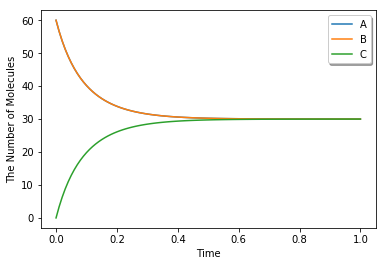

In [14]:
run_simulation(1.0, model=m1, y0={'A': 60, 'B': 60})

Modeling with Python decorators is also available by specifying a function instead of a rate (floating number). When a floating number is set, it is assumed to be a kinetic rate of a mass action reaction, but not a constant velocity.

In [15]:
from functools import reduce
from operator import mul

with reaction_rules():
    A + B == C | (lambda r, *args: 0.1 * reduce(mul, r), 3.0)

m1 = get_model()

For the simplicity, you can directory defining the equation with `Species` names as follows:

In [16]:
with reaction_rules():
    A + B == C | (0.1 * A * B, 3.0)

m1 = get_model()

When you call a `Species` (in the rate law) which is not listed as a reactant or product, it is automatically added to the list as an enzyme.

In [17]:
with reaction_rules():
    S > P | 1.0 * E * S / (30.0 + S)

m1 = get_model()
print(m1.reaction_rules()[0].as_string())
print(m1.reaction_rules()[0].get_descriptor().as_string())

1*S+1*E>1*P+1*E|0
((1.0*E*S)/(30.0+S))


where `E` in the equation is appended to both reacant and product lists.

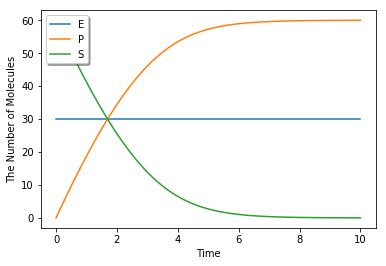

In [18]:
run_simulation(10.0, model=m1, y0={'S': 60, 'E': 30})

Please be careful about typo in `Species`' name. When you make a typo, it is unintentionally recognized as a new enzyme:

In [19]:
with reaction_rules():
    A13P2G > A23P2G | 1500 * A13B2G  # typo: A13P2G -> A13B2G

m1 = get_model()
print(m1.reaction_rules()[0].as_string())

1*A13P2G+1*A13B2G>1*A23P2G+1*A13B2G|0


When you want to disable the automatic declaration of enzymes, inactivate `util.decorator.ENABLE_IMPLICIT_DECLARATION`. If its value is `False`, the above case will raise an error:

In [20]:
util.decorator.ENABLE_IMPLICIT_DECLARATION = False

try:
    with reaction_rules():
        A13P2G > A23P2G | 1500 * A13B2G
except RuntimeError as e:
    print(repr(e))

util.decorator.ENABLE_IMPLICIT_DECLARATION = True

RuntimeError('[A13B2G] is unknown [(1500*{0})].',)


Although E-Cell4 is specialized for a simulation of biochemical reaction network, by using a synthetic reaction rule, ordinary differential equations can be translated intuitively. For example, the Lotka-Volterra equations:

$$\frac{dx}{dt} = Ax - Bxy\\\frac{dy}{dt} = -Cx + Dxy$$

where $A=1.5, B=1, C=3, D=1, x(0)=10, y(0)=5$, are solved as follows:

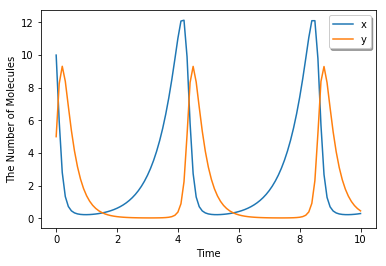

In [21]:
with reaction_rules():
    A, B, C, D = 1.5, 1, 3, 1

    ~x > x | A * x - B * x * y
    ~y > y | -C * y + D * x * y

run_simulation(10, model=get_model(), y0={'x': 10, 'y': 5})

## 6.4. References in a Rate Law

Here, we exlain the details in the rate law definition.

First, when you use simpler definitions of a rate law with `Species`, only a limited number of mathematical functions (e.g. `exp`, `log`, `sin`, `cos`, `tan`, `asin`, `acos`, `atan`, and `pi`) are available there even if you declare the function outside the block.

In [22]:
try:
    from math import erf

    with reaction_rules():
        S > P | erf(S / 30.0)
except TypeError as e:
    print(repr(e))

TypeError('must be real number, not DivExp',)


This error happens because `erf` is tried to be evaluated agaist `S / 30.0`, which is not a floating number. In contrast, the following case is acceptable:

In [23]:
from math import erf

with reaction_rules():
    S > P | erf(2.0) * S

m1 = get_model()
print(m1.reaction_rules()[0].get_descriptor().as_string())

(0.9953222650189527*S)


where only the result of `erf(2.0)`, `0.995322265019`, is passed to the rate law. Thus, the rate law above has no reference to the `erf` function. Similarly, a value of variables declared outside is acceptable, but not as a reference.

In [24]:
kcat, Km = 1.0, 30.0

with reaction_rules():
    S > P | kcat * E * S / (Km + S)

m1 = get_model()
print(m1.reaction_rules()[0].get_descriptor().as_string())
kcat = 2.0
print(m1.reaction_rules()[0].get_descriptor().as_string())

((1.0*E*S)/(30.0+S))
((1.0*E*S)/(30.0+S))


Even if you change the value of a variable, it does **not** affect the rate law.

On the other hand, when you use your own function to define a rate law, it can hold a reference to variables outside.

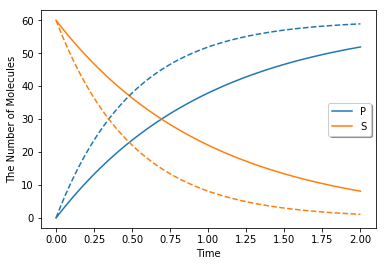

In [25]:
k1 = 1.0

with reaction_rules():
    S > P | (lambda r, *args: k1 * r[0])  # referring k1

m1 = get_model()

obs1 = run_simulation(2, model=m1, y0={"S": 60}, return_type='observer')
k1 = 2.0
obs2 = run_simulation(2, model=m1, y0={"S": 60}, return_type='observer')

viz.plot_number_observer(obs1, '-', obs2, '--')

However, in this case, it is better to make a new model for each set of parameters.

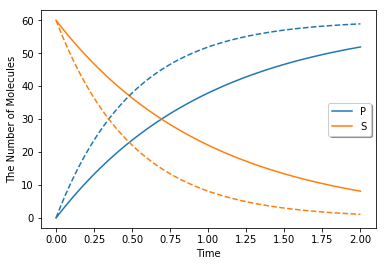

In [26]:
def create_model(k):
    with reaction_rules():
        S > P | k

    return get_model()

obs1 = run_simulation(2, model=create_model(k=1.0), y0={"S": 60}, return_type='observer')
obs2 = run_simulation(2, model=create_model(k=2.0), y0={"S": 60}, return_type='observer')
viz.plot_number_observer(obs1, '-', obs2, '--')

## 6.5. More about ode

In `ode.World`, a value for each `Species` is a floating number. However, for the compatibility, the common member `num_molecules` and `add_molecules` regard the value as an integer.

In [27]:
w = ode.World()
w.add_molecules(Species("A"), 2.5)
print(w.num_molecules(Species("A")))

2


To set/get a real number, use `set_value` and `get_value`:

In [28]:
w.set_value(Species("B"), 2.5)
print(w.get_value(Species("A")))
print(w.get_value(Species("B")))

2.0
2.5


As a default, `ode.Simulator` employs the Rosenblock method, called `ROSENBROCK4_CONTROLLER`, to solve ODEs. In addition to that, two solvers, `EULER` and `RUNGE_KUTTA_CASH_KARP54`, are available. `ROSENBROCK4_CONTROLLER` and `RUNGE_KUTTA_CASH_KARP54` adaptively change the step size during time evolution due to error controll, but `EULER` does not.

In [29]:
with reaction_rules():
    A > ~A | 1.0

m1 = get_model()

w1 = ode.World()
w1.set_value(Species("A"), 1.0)
sim1 = ode.Simulator(w1, m1, ode.EULER)
sim1.set_dt(0.01) # This is only effective for EULER
sim1.run(3.0, obs1)

`ode.ODEFactory` also accepts a solver type and a default step interval.

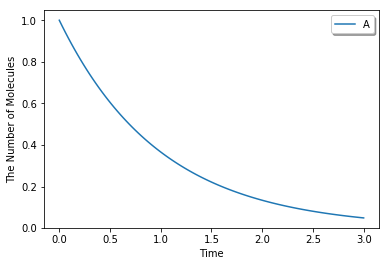

In [30]:
run_simulation(3.0, model=m1, y0={"A": 1.0}, solver=('ode', ode.EULER, 0.01))

See also examples listed below:

* [Glycolysis of Human Erythrocytes](examples/example5.ipynb)
* [Drosophila Circadian Clock](../examples/example2.ipynb)
* [Attractors](../examples/example1.ipynb)